In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [7]:
train_normal = os.path.join('data/train/NORMAL')
train_covid = os.path.join('data/train/PNEUMONIA')

test_normal = os.path.join('data/test/NORMAL')
test_covid = os.path.join('data/test/PNEUMONIA')



In [8]:
print('total training normal images:', len(os.listdir(train_normal)))
print('total training covid images:', len(os.listdir(train_covid)))

print('total testing normal images:', len(os.listdir(test_normal)))
print('total testing covid images:', len(os.listdir(test_covid)))



total training normal images: 74
total training covid images: 74
total testing normal images: 40
total testing covid images: 40


In [4]:
base_model = tf.keras.applications.MobileNet(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)  

In [5]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [6]:
base_model.save("base.h5")

In [7]:
from tensorflow.keras.models import load_model
base_model = load_model('base.h5')

In [12]:
base_model.trainable = False


inputs = tf.keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name='pretrained_mobilenet')
model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)      

In [26]:
TRAINING_DIR = "data/train"
TESTING_DIR = "data/test"

training_datagen = ImageDataGenerator(
    
      rescale = 1./255,
     rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)
        
    )


train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224,224),
    class_mode='binary',
    batch_size=74
      
)

testing_datagen = ImageDataGenerator(
    
      rescale = 1./255
        
    )


test_generator = testing_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224,224),
    class_mode='binary',
    batch_size=20
      
)


model.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.BinaryAccuracy()]
)



history = model.fit(
    train_generator,epochs=50 ,steps_per_epoch=1,verbose=1,validation_data=test_generator,validation_steps=1
)
model.save("transfer_v_3.h5")

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.5217 - binary_accuracy: 0.9595 - val_loss: 0.6121 - val_binary_accuracy: 0.8500
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.7303 - binary_accuracy: 0.6351 - val_loss: 0.4652 - val_binary_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.5034 - binary_accuracy: 1.0000 - val_loss: 0.5205 - val_binary_accuracy: 0.9000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.5210 - binary_accuracy: 0.9595 - val_loss: 0.6172 - val_binary_accuracy: 0.8500
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.5759 - binary_accuracy: 0.8378 - val_loss: 0.5792 - val_binary_accuracy: 0.8000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.5557 - binary_accuracy: 0.8378 - val_loss: 0.5222 - val_binary_accuracy: 0.9000
Epoch 7/50
1/

In [25]:



test = model.evaluate(test_generator, verbose = 1) 


Found 40 images belonging to 2 classes.
     21/Unknown - 23s 1s/step - loss: 0.5021 - binary_accuracy: 1.0000

KeyboardInterrupt: 

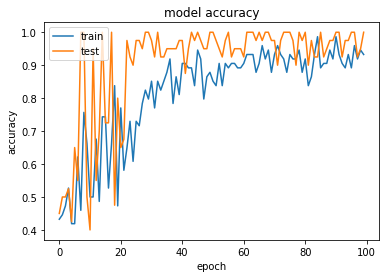

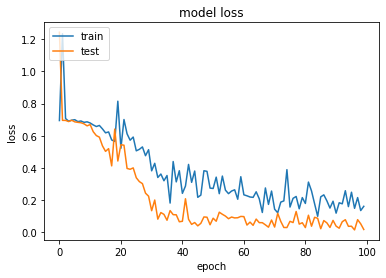

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()


In [9]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "data/train"
VALIDATION_DIR = "data/test"

training_datagen = ImageDataGenerator(
    
      rescale = 1./255,
     rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)
        
    )


train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(200,200),
    class_mode='binary',
    batch_size=74
      
)
validation_datagen = ImageDataGenerator(
    
      rescale = 1./255
        
    )


valid_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(200,200),
    class_mode='binary',
    batch_size=20
      
)




model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(train_generator,epochs=100 ,steps_per_epoch=1,verbose=1,validation_data = valid_generator,validation_steps=2)

model.save("model_v_5.h5")


Found 148 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 128)       0         
_______________________________________

[0.]
 is normal


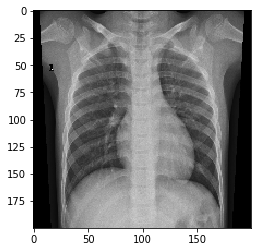

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image



path = 'data/test/NORMAL/NORMAL2-IM-0112-0001 - Copy (2).jpeg'
img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes =model.predict(images, batch_size=10)
print(classes[0])
if classes[0]<0.5:
    print(" is normal")
else:
    print(" is covid")